<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Изучение-данных-из-файла" data-toc-modified-id="Изучение-данных-из-файла-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Изучение данных из файла</a></span><ul class="toc-item"><li><span><a href="#Вывод" data-toc-modified-id="Вывод-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Вывод</a></span></li></ul></li><li><span><a href="#Предобработка-данных" data-toc-modified-id="Предобработка-данных-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Предобработка данных</a></span></li><li><span><a href="#Расчёты-и-добавление-результатов-в-таблицу" data-toc-modified-id="Расчёты-и-добавление-результатов-в-таблицу-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Расчёты и добавление результатов в таблицу</a></span></li><li><span><a href="#Исследовательский-анализ-данных" data-toc-modified-id="Исследовательский-анализ-данных-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Исследовательский анализ данных</a></span></li><li><span><a href="#Общий-вывод" data-toc-modified-id="Общий-вывод-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Общий вывод</a></span></li><li><span><a href="#Чек-лист-готовности-проекта" data-toc-modified-id="Чек-лист-готовности-проекта-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Чек-лист готовности проекта</a></span></li></ul></div>

# Исследование объявлений о продаже квартир

В вашем распоряжении данные сервиса Яндекс.Недвижимость — архив объявлений о продаже квартир в Санкт-Петербурге и соседних населённых пунктах за несколько лет. Нужно научиться определять рыночную стоимость объектов недвижимости. Ваша задача — установить параметры. Это позволит построить автоматизированную систему: она отследит аномалии и мошенническую деятельность. 

По каждой квартире на продажу доступны два вида данных. Первые вписаны пользователем, вторые получены автоматически на основе картографических данных. Например, расстояние до центра, аэропорта, ближайшего парка и водоёма. 

## Изучение данных из файла

In [3]:
import pandas as pd

In [4]:
try:
    rent_data = pd.read_csv('C:\Python_tasks\Yandex_projects\Data\\real_estate_data.csv', sep='\t')
except:
    rent_data = pd.read_csv('https://code.s3.yandex.net/datasets/real_estate_data.csv', sep='\t')

In [5]:
rent_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          23699 non-null  int64  
 1   last_price            23699 non-null  float64
 2   total_area            23699 non-null  float64
 3   first_day_exposition  23699 non-null  object 
 4   rooms                 23699 non-null  int64  
 5   ceiling_height        14504 non-null  float64
 6   floors_total          23613 non-null  float64
 7   living_area           21796 non-null  float64
 8   floor                 23699 non-null  int64  
 9   is_apartment          2775 non-null   object 
 10  studio                23699 non-null  bool   
 11  open_plan             23699 non-null  bool   
 12  kitchen_area          21421 non-null  float64
 13  balcony               12180 non-null  float64
 14  locality_name         23650 non-null  object 
 15  airports_nearest   

Таблица с данными состоит из 21 столбца и 23699 строк.

Столбец first_day_exposition  необходимо привести к типу данных datetime

Столбец floors_total необходимо привести к типу данных int. Количество этажей не может быть дробным числом.

Столбец is_appartment необходимо првисети к типу данных bool. Такой тип данных указан в описании к исходной таблице.

Столбец balcony необходимо привести к типу данных int. КОличество балконов не может быть дробным числом.

Столбцы parks_around3000 и ponds_around3000 необходимо првисети к типу данных int. Количество парков и прудов не может быть дробным числом.


In [6]:
to_int_list = ['floors_total', 'balcony', 'parks_around3000', 'ponds_around3000']

In [7]:
rent_data.isna().mean().to_frame().style.format('{:.2%}').background_gradient('coolwarm')

,0
total_images,0.00%
last_price,0.00%
total_area,0.00%
first_day_exposition,0.00%
rooms,0.00%
ceiling_height,38.80%
floors_total,0.36%
living_area,8.03%
floor,0.00%
is_apartment,88.29%


В столбцах есть пропущенные значения:
- ceiling_height - высота потолков - пропущено 39 % значений. Доля существенная, врядли можно использовать значения этого столбца для исследования, потому что наличие такого большого количества пропусков может сильно иссказить результат. Возможно можно будет увидеть некоторую закономерность разбив имеющиеся значения на категории и посмотреть влияет ли на что-то указанная высота потолка.
- floors_total - всего этажей = пропущено меньше 1% эти значения можно просто выбросить, они не повлияют на результат
- living_area - жилая площадь - пропущено 8% значений. Нужно проверить, возможно жилая площадь пропущена для апартаметов, в информации к данным сказано, что аппартаменты не имеют жилой площади. В этом случае можно будет заменить пропущенные значения на 0.
- is_appartment - апартаменты - пропущено 88% значений. Возможно такой атрибут объявления появился в не так давно, в результате старые данные не имеют такого атрибута. Нужно провести фильтрацию по дате и посмотреть с какого момента появляются заполненные значения.
- kitchen_area - площадь кухни - пропущено 10% значений. Можно попробовать заполнить значения медианой. Нужно посмотреть внимательнее.
- balcony - балконы - пропущено 48% значений. Очень много пропусков. Возможно также атрибут появлися не так давно. Нужно проверить по дате появления первых значений. Врядли можно будет использовать этот столбец для исследования всех данных. Возможно можно будет оценить что-то используя только заполненые значения.
- locality_name - назнавние населенного пункта - пропущено менее 1% значений. Эти данные можно отбросить.
- airports_nearest, cityCenters_nearest, parks_around3000, ponds_around3000 - расстояние до аэропорта, расстояние до цента, количество парков в радиусе 3 км, количесвто прудов в радиусе 3 км- пропущено 23% значений. Вероятно так же данные атрибуты были введены в одно время. Примерно равное количество пропусков. Нужно проверить эту гипотезу.
- parks_nearest, ponds_nearest - расстояние в метрах до парка, расстояние в метрах до пруда. Пропущено более 60% значений. Нужно проверить гипотезу введения этого атрибута одновременно.
- days_exposition - количество дней, когда объявление было активно - пропущено 13 % значений. Вероятно в этих значениях находятся действующие в настоящее время объявления. Думаю что с этими значениями делать ничего не нужно.


In [8]:
to_drop_nas = ['floors_total', 'locality_name'] # выделим столбцы для которых нужно отбросить пропущенные значения

In [9]:
living_area_nas_in_apartment = rent_data[rent_data['living_area'].isna() & (rent_data['is_apartment'].isna() == False)].shape[0] / rent_data[rent_data['living_area'].isna()].shape[0]
living_area_nas_in_apartment

0.0630583289542827

In [10]:
rent_data.query('living_area ==  0')

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition


In [11]:
rent_data.query('is_apartment == True').head()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
543,11,12790000.0,56.6,2018-11-06T00:00:00,2,3.50,3.0,29.4,1,True,...,NaN,NaN,Петергоф,35248.0,30437.0,3.0,53.0,3.0,22.0,NaN
916,11,8183000.0,70.0,2018-01-11T00:00:00,2,3.12,3.0,40.0,3,True,...,NaN,2.0,Санкт-Петербург,45796.0,21729.0,0.0,NaN,1.0,754.0,179.0
1109,1,34878556.0,95.8,2014-12-09T00:00:00,2,NaN,6.0,58.3,5,True,...,20.0,1.0,Санкт-Петербург,21860.0,318.0,2.0,160.0,3.0,569.0,1572.0
1608,12,2150000.0,20.1,2019-01-30T00:00:00,1,NaN,9.0,NaN,1,True,...,NaN,NaN,Санкт-Петербург,26646.0,12147.0,0.0,NaN,0.0,NaN,13.0
2759,11,7500000.0,152.0,2018-07-27T00:00:00,3,3.00,3.0,NaN,1,True,...,NaN,1.0,Всеволожск,NaN,NaN,NaN,NaN,NaN,NaN,7.0


Проверив связь между имеющиеся в распоряжении данные можно сделать вывод, что гипотеза об отсутствии жилой площади для апартаментов не подтвердилась. Количество пропущенных значений для солбца жилая площадь значительно превышает количество заполненных значений в столбце апартаменты. Использовать данные в столбце апартаменты для заполнения пропусков жилой площади не получится. Также по моему мнению не верно будет заполнять пропущенные значения 0, поскольку значение 0 для жилой площади в данных не встречается. Даже для строк, в которых явно указано, что это апартаменты. 

Для заполнения пропусков в столбце living_area можно рассчитать медианную долю жилой площади от общей площади и высчитать по каждой пропущенной строке приблизительную жилую площадь.



Для заполнения пропусков в столбце kitchen_area можно рассчитать медианную долю площади кухни от общей площади и высчитать по каждой пропущенной строке приблизительную площадь кухни.

In [12]:

to_replase_nans = ['kitchen_area', 'living_area']

Для столбцов в которых пропущено более 20% значений заполнять пропуски не целесообразно. Это приведет к искажению результатов. Проверять гипотезы по таким данным придется избавившись от пропусков.

In [13]:
rent_data.describe()

,total_images,last_price,total_area,rooms,ceiling_height,floors_total,living_area,floor,kitchen_area,balcony,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
count,23699.000000,2.369900e+04,23699.000000,23699.000000,14504.000000,23613.000000,21796.000000,23699.000000,21421.000000,12180.000000,18157.000000,18180.000000,18181.000000,8079.000000,18181.000000,9110.000000,20518.000000
mean,9.858475,6.541549e+06,60.348651,2.070636,2.771499,10.673824,34.457852,5.892358,10.569807,1.150082,28793.672193,14191.277833,0.611408,490.804555,0.770255,517.980900,180.888634
std,5.682529,1.088701e+07,35.654083,1.078405,1.261056,6.597173,22.030445,4.885249,5.905438,1.071300,12630.880622,8608.386210,0.802074,342.317995,0.938346,277.720643,219.727988
min,0.000000,1.219000e+04,12.000000,0.000000,1.000000,1.000000,2.000000,1.000000,1.300000,0.000000,0.000000,181.000000,0.000000,1.000000,0.000000,13.000000,1.000000
25%,6.000000,3.400000e+06,40.000000,1.000000,2.520000,5.000000,18.600000,2.000000,7.000000,0.000000,18585.000000,9238.000000,0.000000,288.000000,0.000000,294.000000,45.000000
50%,9.000000,4.650000e+06,52.000000,2.000000,2.650000,9.000000,30.000000,4.000000,9.100000,1.000000,26726.000000,13098.500000,0.000000,455.000000,1.000000,502.000000,95.000000
75%,14.000000,6.800000e+06,69.900000,3.000000,2.800000,16.000000,42.300000,8.000000,12.000000,2.000000,37273.000000,16293.000000,1.000000,612.000000,1.000000,729.000000,232.000000
max,50.000000,7.630000e+08,900.000000,19.000000,100.000000,60.000000,409.700000,33.000000,112.000000,5.000000,84869.000000,65968.000000,3.000000,3190.000000,3.000000,1344.000000,1580.000000


Просмотрев описание числовых столбцов можно сделать следующие выводы:
- total_images - количество фотографий распределено приблизительно равномерно. Среднее значение практически равно медиане (9.85 = 9)
- last_price - имеются как малые значения так и очень большие. Вероятно имеются выбросы.
- total_area - среднее и медиана отличаются значительно, вероятно квартиры с большими площадями сильно смещают среднее значение.
- rooms - данные распределены равномерно медиана и среднее совпадают.
- ceiling_height - данные распределены равномерно, хотя смущает минимальное значение 1 метр и максимальное 100.
- floors_total - данные похожи на реальные, минимум 1, максимум 60 (видимо высотки в Питере), медиана 9 этажей, среднее смещено в большую сторону, вероятно из-зы высоток.
- living_area - данные распределены схожим образом со столбцом total_area, так же среднее смещено от медианы. Смещение приблизительно одинаковое, что и для всей площади. Похоже на реальные данные.
- floor - данные распределены схожим образом что и в столбце floors_total, также есть смещение среднего из-за выбросов (высоток).
- kitchen_area - данные распределены аналогично total_area и living_area.
- balcony - чаще всего встречаются квартиры с одним балконом. Хотя данных только ~ 50 %
- airports_nearest - в среднем аэропорт находится в 26 - 28 километрах от квартир. Смущает указанный 0 (возможно по ошибке) Также странно указывать 86 км(максимальное значение), такое значение врядли можно считать фактором, говорящим в пользу квартиры.
- cityCenters_nearest - в среднем центр города (видимо речь идет о Санкт-Петербурге) находится в 13-14 км от квартир. Здесь минимум (181 м) похож на реальное значение, а указание 66 км(максимум) от центра смотрится странно.
- parks_around3000 - парки поблизости, медиана равна 0, то есть как минимум для половины выборки нет парков поблизости, соответсвтенно и не дожно быть указано расстояние до ближайшего парка, это объясняет большшое количество пропусков в столбце parks_nearest
- parks_nearest - расстояние до парков, медиана 455 метров, среднее смещено из-за наличия больших значений.
- ponds_around3000 - количество водоемов поблизости, медиана равна 1, то есть как минимум для половины выборки водоем поблизости есть. 
- ponds_nearest - расстояние до водоема медиана - 500 практически совпадает со средним 517.
- days_exposition - количество дней до снятия объявления. Медиана - 95, среднее сильно смещено из-за наличия очень больших значений. Максимум - 1580 дней или более 4 лет.

In [14]:
rent_data.head()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
0,20,13000000.0,108.0,2019-03-07T00:00:00,3,2.70,16.0,51.0,8,NaN,...,25.0,NaN,Санкт-Петербург,18863.0,16028.0,1.0,482.0,2.0,755.0,NaN
1,7,3350000.0,40.4,2018-12-04T00:00:00,1,NaN,11.0,18.6,1,NaN,...,11.0,2.0,посёлок Шушары,12817.0,18603.0,0.0,NaN,0.0,NaN,81.0
2,10,5196000.0,56.0,2015-08-20T00:00:00,2,NaN,5.0,34.3,4,NaN,...,8.3,0.0,Санкт-Петербург,21741.0,13933.0,1.0,90.0,2.0,574.0,558.0
3,0,64900000.0,159.0,2015-07-24T00:00:00,3,NaN,14.0,NaN,9,NaN,...,NaN,0.0,Санкт-Петербург,28098.0,6800.0,2.0,84.0,3.0,234.0,424.0
4,2,10000000.0,100.0,2018-06-19T00:00:00,2,3.03,14.0,32.0,13,NaN,...,41.0,NaN,Санкт-Петербург,31856.0,8098.0,2.0,112.0,1.0,48.0,121.0


### Вывод

## Предобработка данных

In [15]:
rent_data.dropna(subset=to_drop_nas, inplace=True)
rent_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23565 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          23565 non-null  int64  
 1   last_price            23565 non-null  float64
 2   total_area            23565 non-null  float64
 3   first_day_exposition  23565 non-null  object 
 4   rooms                 23565 non-null  int64  
 5   ceiling_height        14481 non-null  float64
 6   floors_total          23565 non-null  float64
 7   living_area           21700 non-null  float64
 8   floor                 23565 non-null  int64  
 9   is_apartment          2760 non-null   object 
 10  studio                23565 non-null  bool   
 11  open_plan             23565 non-null  bool   
 12  kitchen_area          21343 non-null  float64
 13  balcony               12090 non-null  float64
 14  locality_name         23565 non-null  object 
 15  airports_nearest   

Пропущенные значения для столбцов floors_total и locality_name удалены.

Заполним пропуски в столбцах kitchen_area и living_area. Для заполнения рассчитаем площади как произведение соотвествующей общей площади на значение медианное отношение искомой площади к жилой.

In [16]:
def fill_na_columns(df, column):
    median_part = (df[column] / df.total_area).median()
    df.loc[df[column].isna(), column] = df.total_area * median_part

In [17]:
for item in to_replase_nans:
    fill_na_columns(rent_data,item)

In [18]:
rent_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23565 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          23565 non-null  int64  
 1   last_price            23565 non-null  float64
 2   total_area            23565 non-null  float64
 3   first_day_exposition  23565 non-null  object 
 4   rooms                 23565 non-null  int64  
 5   ceiling_height        14481 non-null  float64
 6   floors_total          23565 non-null  float64
 7   living_area           23565 non-null  float64
 8   floor                 23565 non-null  int64  
 9   is_apartment          2760 non-null   object 
 10  studio                23565 non-null  bool   
 11  open_plan             23565 non-null  bool   
 12  kitchen_area          23565 non-null  float64
 13  balcony               12090 non-null  float64
 14  locality_name         23565 non-null  object 
 15  airports_nearest   

In [19]:
rent_data['first_day_exposition'] = pd.to_datetime(rent_data['first_day_exposition'], format='%Y-%m-%dT%H:%M:%S')

In [20]:
rent_data.first_day_exposition.max() - rent_data.first_day_exposition.min()

Timedelta('1618 days 00:00:00')

В выборке представленны данные за более чем 4 года

In [21]:
for column in to_int_list:
    rent_data[column] = rent_data[column].astype('Int64')

In [22]:
rent_data['is_apartment'] = rent_data['is_apartment'].astype('boolean')

In [23]:
rent_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23565 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   total_images          23565 non-null  int64         
 1   last_price            23565 non-null  float64       
 2   total_area            23565 non-null  float64       
 3   first_day_exposition  23565 non-null  datetime64[ns]
 4   rooms                 23565 non-null  int64         
 5   ceiling_height        14481 non-null  float64       
 6   floors_total          23565 non-null  Int64         
 7   living_area           23565 non-null  float64       
 8   floor                 23565 non-null  int64         
 9   is_apartment          2760 non-null   boolean       
 10  studio                23565 non-null  bool          
 11  open_plan             23565 non-null  bool          
 12  kitchen_area          23565 non-null  float64       
 13  balcony         

## Расчёты и добавление результатов в таблицу

In [24]:
rent_data['price_per_meter'] = rent_data.last_price / rent_data.total_area

In [25]:
rent_data['day'] = rent_data.first_day_exposition.dt.day_of_week
rent_data['month'] = rent_data.first_day_exposition.dt.month
rent_data['year'] = rent_data.first_day_exposition.dt.year

In [26]:
def get_floor_category(floor, floors_total):
    if floor == 1:
        return 'Первый'
    elif floor == floors_total:
        return 'Последний'
    else:
        return 'Другой'

In [27]:
rent_data['floor_category'] = rent_data.apply(lambda x: get_floor_category(x['floor'], x['floors_total']), axis=1)

In [28]:
rent_data.floor_category.value_counts()

Другой       17326
Последний     3330
Первый        2909
Name: floor_category, dtype: int64

In [29]:
rent_data['living_area_part'] = rent_data['living_area'] / rent_data['total_area']
rent_data['kitchen_area_part'] = rent_data['kitchen_area'] / rent_data['total_area']

## Исследовательский анализ данных

<AxesSubplot:>

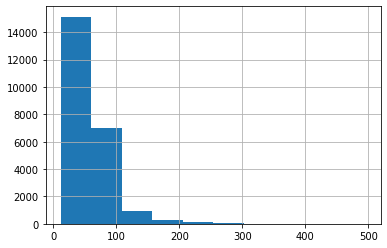

In [30]:
rent_data.loc[rent_data['total_area']< 500, 'total_area'].hist()

<AxesSubplot:>

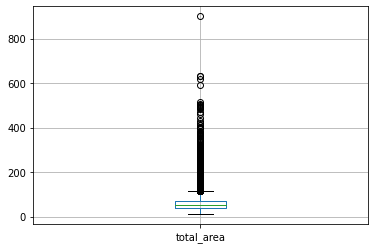

In [31]:
rent_data.boxplot(column='total_area')

In [43]:
low_q_index = rent_data[rent_data['ceiling_height'] > rent_data['ceiling_height'].quantile(0.01)].index

In [42]:
rent_data.drop(low_q_index)

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,ponds_around3000,ponds_nearest,days_exposition,price_per_meter,day,month,year,floor_category,living_area_part,kitchen_area_part
0,20,13000000.0,108.00,2019-03-07,3,2.70,16,51.000000,8,<NA>,...,2,755.0,NaN,120370.370370,3,3,2019,Другой,0.472222,0.231481
1,7,3350000.0,40.40,2018-12-04,1,NaN,11,18.600000,1,<NA>,...,0,NaN,81.0,82920.792079,1,12,2018,Первый,0.460396,0.272277
2,10,5196000.0,56.00,2015-08-20,2,NaN,5,34.300000,4,<NA>,...,2,574.0,558.0,92785.714286,3,8,2015,Другой,0.612500,0.148214
3,0,64900000.0,159.00,2015-07-24,3,NaN,14,90.345393,9,<NA>,...,3,234.0,424.0,408176.100629,4,7,2015,Другой,0.568210,0.172363
4,2,10000000.0,100.00,2018-06-19,2,3.03,14,32.000000,13,<NA>,...,1,48.0,121.0,100000.000000,1,6,2018,Другой,0.320000,0.410000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23694,9,9700000.0,133.81,2017-03-21,3,3.70,5,73.300000,3,<NA>,...,3,381.0,NaN,72490.845228,1,3,2017,Другой,0.547792,0.103356
23695,14,3100000.0,59.00,2018-01-15,3,NaN,5,38.000000,4,<NA>,...,<NA>,NaN,45.0,52542.372881,0,1,2018,Другой,0.644068,0.144068
23696,18,2500000.0,56.70,2018-02-11,2,NaN,3,29.700000,1,<NA>,...,<NA>,NaN,NaN,44091.710758,6,2,2018,Первый,0.523810,0.172363
23697,13,11475000.0,76.75,2017-03-28,2,3.00,17,43.610119,12,<NA>,...,3,196.0,602.0,149511.400651,1,3,2017,Другой,0.568210,0.303583


In [33]:
rent_data.last_price.describe()

count    2.356500e+04
mean     6.540058e+06
std      1.091093e+07
min      1.219000e+04
25%      3.400000e+06
50%      4.646000e+06
75%      6.790000e+06
max      7.630000e+08
Name: last_price, dtype: float64

<AxesSubplot:>

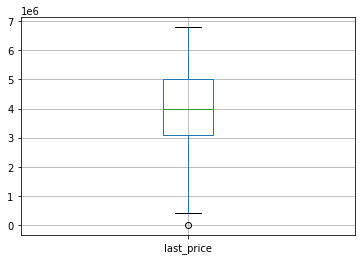

In [34]:
quant_75 = rent_data.last_price.quantile(0.75)
rent_data.query('last_price < @quant_75').boxplot(column='last_price')

## Общий вывод

## Чек-лист готовности проекта

Поставьте 'x' в выполненных пунктах. Далее нажмите Shift+Enter.

- [x]  открыт файл
- [ ]  файлы изучены (выведены первые строки, метод info())
- [ ]  определены пропущенные значения
- [ ]  заполнены пропущенные значения
- [ ]  есть пояснение, какие пропущенные значения обнаружены
- [ ]  изменены типы данных
- [ ]  есть пояснение, в каких столбцах изменены типы и почему
- [ ]  посчитано и добавлено в таблицу: цена квадратного метра
- [ ]  посчитано и добавлено в таблицу: день недели, месяц и год публикации объявления
- [ ]  посчитано и добавлено в таблицу: этаж квартиры; варианты — первый, последний, другой
- [ ]  посчитано и добавлено в таблицу: соотношение жилой и общей площади, а также отношение площади кухни к общей
- [ ]  изучены следующие параметры: площадь, цена, число комнат, высота потолков
- [ ]  построены гистограммы для каждого параметра
- [ ]  выполнено задание: "Изучите время продажи квартиры. Постройте гистограмму. Посчитайте среднее и медиану. Опишите, сколько обычно занимает продажа. Когда можно считать, что продажи прошли очень быстро, а когда необычно долго?"
- [ ]  выполнено задание: "Уберите редкие и выбивающиеся значения. Опишите, какие особенности обнаружили."
- [ ]  выполнено задание: "Какие факторы больше всего влияют на стоимость квартиры? Изучите, зависит ли цена от квадратного метра, числа комнат, этажа (первого или последнего), удалённости от центра. Также изучите зависимость от даты размещения: дня недели, месяца и года. "Выберите 10 населённых пунктов с наибольшим числом объявлений. Посчитайте среднюю цену квадратного метра в этих населённых пунктах. Выделите населённые пункты с самой высокой и низкой стоимостью жилья. Эти данные можно найти по имени в столбце '*locality_name'*. "
- [ ]  выполнено задание: "Изучите предложения квартир: для каждой квартиры есть информация о расстоянии до центра. Выделите квартиры в Санкт-Петербурге (*'locality_name'*). Ваша задача — выяснить, какая область входит в центр. Создайте столбец с расстоянием до центра в километрах: округлите до целых значений. После этого посчитайте среднюю цену для каждого километра. Постройте график: он должен показывать, как цена зависит от удалённости от центра. Определите границу, где график сильно меняется — это и будет центральная зона. "
- [ ]  выполнено задание: "Выделите сегмент квартир в центре. Проанализируйте эту территорию и изучите следующие параметры: площадь, цена, число комнат, высота потолков. Также выделите факторы, которые влияют на стоимость квартиры (число комнат, этаж, удалённость от центра, дата размещения объявления). Сделайте выводы. Отличаются ли они от общих выводов по всему городу?"
- [ ]  в каждом этапе есть выводы
- [ ]  есть общий вывод